# StyleGAN2

In [1]:
%tensorflow_version 1.x
import tensorflow as tf

# Download the code
# !git clone https://github.com/NVlabs/stylegan2.git

TensorFlow 1.x selected.


In [2]:
# Load from GDrive directly

tf_data_location = '/content/drive/MyDrive/Work/Regular/Unetiq/ARNO/datasets/Bonn/tf_data/tf-dataset-bonn-labeled.zip'

!mkdir /content/datasets
!cp {tf_data_location} /content/datasets/
%cd /content/datasets
!unzip /content/datasets/tf-dataset-bonn-labeled.zip
!mv -r /content/datasets/bonn /content/datasets/custom

/content/datasets
Archive:  /content/datasets/tf-dataset-bonn-labeled.zip
   creating: bonn/
  inflating: bonn/bonn-r05.tfrecords  
  inflating: bonn/bonn-r04.tfrecords  
  inflating: bonn/bonn-r07.tfrecords  
  inflating: bonn/bonn-r06.tfrecords  
  inflating: bonn/bonn-rxx.labels    
   creating: bonn/.ipynb_checkpoints/
  inflating: bonn/bonn-r03.tfrecords  
  inflating: bonn/bonn-r02.tfrecords  


In [3]:
# !cp /content/drive/MyDrive/Work/Regular/Unetiq/ARNO/datasets/Bonn/network-snapshot-002670.pkl /content/

In [2]:
%cd /content/stylegan2/training

/content/stylegan2/training


In [3]:
%%writefile training_loop.py
# Copyright (c) 2019, NVIDIA Corporation. All rights reserved.
#
# This work is made available under the Nvidia Source Code License-NC.
# To view a copy of this license, visit
# https://nvlabs.github.io/stylegan2/license.html

"""Main training script."""

import numpy as np
import tensorflow as tf
import dnnlib
import dnnlib.tflib as tflib
from dnnlib.tflib.autosummary import autosummary

from training import dataset
from training import misc
from metrics import metric_base

# ----------------------------------------------------------------------------

# Set up ClearML

from clearml import Task, Logger

import os
task = Task.init(project_name=os.environ["CLEARML_PROJECT_NAME"], task_name=os.environ["CLEARML_TASK_NAME"], continue_last_task=True)
task.connect_configuration('/root/clearml.conf')
logger = task.get_logger()
logger.set_default_upload_destination(uri='gs://clearml-bucket-0')

# ----------------------------------------------------------------------------

# Just-in-time processing of training images before feeding them to the networks.

def process_reals(x, labels, lod, mirror_augment, drange_data, drange_net):
    with tf.name_scope('DynamicRange'):
        x = tf.cast(x, tf.float32)
        x = misc.adjust_dynamic_range(x, drange_data, drange_net)
    if mirror_augment:
        with tf.name_scope('MirrorAugment'):
            x = tf.where(tf.random_uniform([tf.shape(x)[0]]) < 0.5, x, tf.reverse(x, [3]))
    with tf.name_scope('FadeLOD'): # Smooth crossfade between consecutive levels-of-detail.
        s = tf.shape(x)
        y = tf.reshape(x, [-1, s[1], s[2]//2, 2, s[3]//2, 2])
        y = tf.reduce_mean(y, axis=[3, 5], keepdims=True)
        y = tf.tile(y, [1, 1, 1, 2, 1, 2])
        y = tf.reshape(y, [-1, s[1], s[2], s[3]])
        x = tflib.lerp(x, y, lod - tf.floor(lod))
    with tf.name_scope('UpscaleLOD'): # Upscale to match the expected input/output size of the networks.
        s = tf.shape(x)
        factor = tf.cast(2 ** tf.floor(lod), tf.int32)
        x = tf.reshape(x, [-1, s[1], s[2], 1, s[3], 1])
        x = tf.tile(x, [1, 1, 1, factor, 1, factor])
        x = tf.reshape(x, [-1, s[1], s[2] * factor, s[3] * factor])
    return x, labels

#----------------------------------------------------------------------------
# Evaluate time-varying training parameters.

def training_schedule(
    cur_nimg,
    training_set,
    lod_initial_resolution  = None,     # Image resolution used at the beginning.
    lod_training_kimg       = 600,      # Thousands of real images to show before doubling the resolution.
    lod_transition_kimg     = 600,      # Thousands of real images to show when fading in new layers.
    minibatch_size_base     = 16,       # Global minibatch size.
    minibatch_size_dict     = {},       # Resolution-specific overrides.
    minibatch_gpu_base      = 4,        # Number of samples processed at a time by one GPU.
    minibatch_gpu_dict      = {},       # Resolution-specific overrides.
    G_lrate_base            = 0.002,    # Learning rate for the generator.
    G_lrate_dict            = {},       # Resolution-specific overrides.
    D_lrate_base            = 0.002,    # Learning rate for the discriminator.
    D_lrate_dict            = {},       # Resolution-specific overrides.
    lrate_rampup_kimg       = 0,        # Duration of learning rate ramp-up.
    tick_kimg_base          = 160,        # Default interval of progress snapshots.
    tick_kimg_dict          = {8:28, 16:24, 32:20, 64:16, 128:12, 256:8, 512:6, 1024:4}): # Resolution-specific overrides.

    # Initialize result dict.
    s = dnnlib.EasyDict()
    s.kimg = cur_nimg / 1000.0

    # Training phase.
    phase_dur = lod_training_kimg + lod_transition_kimg
    phase_idx = int(np.floor(s.kimg / phase_dur)) if phase_dur > 0 else 0
    phase_kimg = s.kimg - phase_idx * phase_dur

    # Level-of-detail and resolution.
    if lod_initial_resolution is None:
        s.lod = 0.0
    else:
        s.lod = training_set.resolution_log2
        s.lod -= np.floor(np.log2(lod_initial_resolution))
        s.lod -= phase_idx
        if lod_transition_kimg > 0:
            s.lod -= max(phase_kimg - lod_training_kimg, 0.0) / lod_transition_kimg
        s.lod = max(s.lod, 0.0)
    s.resolution = 2 ** (training_set.resolution_log2 - int(np.floor(s.lod)))

    # Minibatch size.
    s.minibatch_size = minibatch_size_dict.get(s.resolution, minibatch_size_base)
    s.minibatch_gpu = minibatch_gpu_dict.get(s.resolution, minibatch_gpu_base)

    # Learning rate.
    s.G_lrate = G_lrate_dict.get(s.resolution, G_lrate_base)
    s.D_lrate = D_lrate_dict.get(s.resolution, D_lrate_base)
    if lrate_rampup_kimg > 0:
        rampup = min(s.kimg / lrate_rampup_kimg, 1.0)
        s.G_lrate *= rampup
        s.D_lrate *= rampup

    # Other parameters.
    s.tick_kimg = tick_kimg_dict.get(s.resolution, tick_kimg_base)
    return s

#----------------------------------------------------------------------------
# Main training script.

def training_loop(
    G_args                  = {},       # Options for generator network.
    D_args                  = {},       # Options for discriminator network.
    G_opt_args              = {},       # Options for generator optimizer.
    D_opt_args              = {},       # Options for discriminator optimizer.
    G_loss_args             = {},       # Options for generator loss.
    D_loss_args             = {},       # Options for discriminator loss.
    dataset_args            = {},       # Options for dataset.load_dataset().
    sched_args              = {},       # Options for train.TrainingSchedule.
    grid_args               = {},       # Options for train.setup_snapshot_image_grid().
    metric_arg_list         = [],       # Options for MetricGroup.
    tf_config               = {},       # Options for tflib.init_tf().
    data_dir                = None,     # Directory to load datasets from.
    G_smoothing_kimg        = 10.0,     # Half-life of the running average of generator weights.
    minibatch_repeats       = 4,        # Number of minibatches to run before adjusting training parameters.
    lazy_regularization     = True,     # Perform regularization as a separate training step?
    G_reg_interval          = 4,        # How often the perform regularization for G? Ignored if lazy_regularization=False.
    D_reg_interval          = 16,       # How often the perform regularization for D? Ignored if lazy_regularization=False.
    reset_opt_for_new_lod   = True,     # Reset optimizer internal state (e.g. Adam moments) when new layers are introduced?
    total_kimg              = 25000,    # Total length of the training, measured in thousands of real images.
    mirror_augment          = False,    # Enable mirror augment?
    drange_net              = [-1,1],   # Dynamic range used when feeding image data to the networks.
    image_snapshot_ticks    = 1,       # How often to save image snapshots? None = only save 'reals.png' and 'fakes-init.png'.
    network_snapshot_ticks  = 1,       # How often to save network snapshots? None = only save 'networks-final.pkl'.
    save_tf_graph           = False,    # Include full TensorFlow computation graph in the tfevents file?
    save_weight_histograms  = False,    # Include weight histograms in the tfevents file?
    resume_pkl              = "/content/network-snapshot-001167.pkl",     # Network pickle to resume training from, None = train from scratch.
    resume_kimg             = 1167,      # Assumed training progress at the beginning. Affects reporting and training schedule.
    resume_time             = 0.0,      # Assumed wallclock time at the beginning. Affects reporting.
    resume_with_new_nets    = False):   # Construct new networks according to G_args and D_args before resuming training?

    # Initialize dnnlib and TensorFlow.
    tflib.init_tf(tf_config)
    num_gpus = dnnlib.submit_config.num_gpus

    # Load training set.
    training_set = dataset.load_dataset(data_dir=dnnlib.convert_path(data_dir), verbose=True, **dataset_args)
    grid_size, grid_reals, grid_labels = misc.setup_snapshot_image_grid(training_set, **grid_args)
    misc.save_image_grid(grid_reals, dnnlib.make_run_dir_path('reals.png'), drange=training_set.dynamic_range, grid_size=grid_size,
                        iteration=0, kimg=0, t1="real_grid", t2="grid")

    # Construct or load networks.
    with tf.device('/gpu:0'):
        if resume_pkl is None or resume_with_new_nets:
            print('Constructing networks...')
            G = tflib.Network('G', num_channels=training_set.shape[0], resolution=training_set.shape[1], label_size=training_set.label_size, **G_args)
            D = tflib.Network('D', num_channels=training_set.shape[0], resolution=training_set.shape[1], label_size=training_set.label_size, **D_args)
            Gs = G.clone('Gs')
        if resume_pkl is not None:
            print('Loading networks from "%s"...' % resume_pkl)
            rG, rD, rGs = misc.load_pkl(resume_pkl)
            if resume_with_new_nets: G.copy_vars_from(rG); D.copy_vars_from(rD); Gs.copy_vars_from(rGs)
            else: G = rG; D = rD; Gs = rGs

    # Print layers and generate initial image snapshot.
    G.print_layers(); D.print_layers()
    sched = training_schedule(cur_nimg=total_kimg*1000, training_set=training_set, **sched_args)
    grid_latents = np.random.randn(np.prod(grid_size), *G.input_shape[1:])
    grid_fakes = Gs.run(grid_latents, grid_labels, is_validation=True, minibatch_size=sched.minibatch_gpu)
    misc.save_image_grid(grid_fakes, dnnlib.make_run_dir_path('fakes_init.png'), drange=drange_net, grid_size=grid_size)

    # Setup training inputs.
    print('Building TensorFlow graph...')
    with tf.name_scope('Inputs'), tf.device('/cpu:0'):
        lod_in               = tf.placeholder(tf.float32, name='lod_in', shape=[])
        lrate_in             = tf.placeholder(tf.float32, name='lrate_in', shape=[])
        minibatch_size_in    = tf.placeholder(tf.int32, name='minibatch_size_in', shape=[])
        minibatch_gpu_in     = tf.placeholder(tf.int32, name='minibatch_gpu_in', shape=[])
        minibatch_multiplier = minibatch_size_in // (minibatch_gpu_in * num_gpus)
        Gs_beta              = 0.5 ** tf.div(tf.cast(minibatch_size_in, tf.float32), G_smoothing_kimg * 1000.0) if G_smoothing_kimg > 0.0 else 0.0

    # Setup optimizers.
    G_opt_args = dict(G_opt_args)
    D_opt_args = dict(D_opt_args)
    for args, reg_interval in [(G_opt_args, G_reg_interval), (D_opt_args, D_reg_interval)]:
        args['minibatch_multiplier'] = minibatch_multiplier
        args['learning_rate'] = lrate_in
        if lazy_regularization:
            mb_ratio = reg_interval / (reg_interval + 1)
            args['learning_rate'] *= mb_ratio
            if 'beta1' in args: args['beta1'] **= mb_ratio
            if 'beta2' in args: args['beta2'] **= mb_ratio
    G_opt = tflib.Optimizer(name='TrainG', **G_opt_args)
    D_opt = tflib.Optimizer(name='TrainD', **D_opt_args)
    G_reg_opt = tflib.Optimizer(name='RegG', share=G_opt, **G_opt_args)
    D_reg_opt = tflib.Optimizer(name='RegD', share=D_opt, **D_opt_args)

    # Build training graph for each GPU.
    data_fetch_ops = []
    for gpu in range(num_gpus):
        with tf.name_scope('GPU%d' % gpu), tf.device('/gpu:%d' % gpu):

            # Create GPU-specific shadow copies of G and D.
            G_gpu = G if gpu == 0 else G.clone(G.name + '_shadow')
            D_gpu = D if gpu == 0 else D.clone(D.name + '_shadow')

            # Fetch training data via temporary variables.
            with tf.name_scope('DataFetch'):
                sched = training_schedule(cur_nimg=int(resume_kimg*1000), training_set=training_set, **sched_args)
                reals_var = tf.Variable(name='reals', trainable=False, initial_value=tf.zeros([sched.minibatch_gpu] + training_set.shape))
                labels_var = tf.Variable(name='labels', trainable=False, initial_value=tf.zeros([sched.minibatch_gpu, training_set.label_size]))
                reals_write, labels_write = training_set.get_minibatch_tf()
                reals_write, labels_write = process_reals(reals_write, labels_write, lod_in, mirror_augment, training_set.dynamic_range, drange_net)
                reals_write = tf.concat([reals_write, reals_var[minibatch_gpu_in:]], axis=0)
                labels_write = tf.concat([labels_write, labels_var[minibatch_gpu_in:]], axis=0)
                data_fetch_ops += [tf.assign(reals_var, reals_write)]
                data_fetch_ops += [tf.assign(labels_var, labels_write)]
                reals_read = reals_var[:minibatch_gpu_in]
                labels_read = labels_var[:minibatch_gpu_in]

            # Evaluate loss functions.
            lod_assign_ops = []
            if 'lod' in G_gpu.vars: lod_assign_ops += [tf.assign(G_gpu.vars['lod'], lod_in)]
            if 'lod' in D_gpu.vars: lod_assign_ops += [tf.assign(D_gpu.vars['lod'], lod_in)]
            with tf.control_dependencies(lod_assign_ops):
                with tf.name_scope('G_loss'):
                    G_loss, G_reg = dnnlib.util.call_func_by_name(G=G_gpu, D=D_gpu, opt=G_opt, training_set=training_set, minibatch_size=minibatch_gpu_in, **G_loss_args)
                with tf.name_scope('D_loss'):
                    D_loss, D_reg = dnnlib.util.call_func_by_name(G=G_gpu, D=D_gpu, opt=D_opt, training_set=training_set, minibatch_size=minibatch_gpu_in, reals=reals_read, labels=labels_read, **D_loss_args)

            # Register gradients.
            if not lazy_regularization:
                if G_reg is not None: G_loss += G_reg
                if D_reg is not None: D_loss += D_reg
            else:
                if G_reg is not None: G_reg_opt.register_gradients(tf.reduce_mean(G_reg * G_reg_interval), G_gpu.trainables)
                if D_reg is not None: D_reg_opt.register_gradients(tf.reduce_mean(D_reg * D_reg_interval), D_gpu.trainables)
            G_opt.register_gradients(tf.reduce_mean(G_loss), G_gpu.trainables)
            D_opt.register_gradients(tf.reduce_mean(D_loss), D_gpu.trainables)

    # Setup training ops.
    data_fetch_op = tf.group(*data_fetch_ops)
    G_train_op = G_opt.apply_updates()
    D_train_op = D_opt.apply_updates()
    G_reg_op = G_reg_opt.apply_updates(allow_no_op=True)
    D_reg_op = D_reg_opt.apply_updates(allow_no_op=True)
    Gs_update_op = Gs.setup_as_moving_average_of(G, beta=Gs_beta)

    # Finalize graph.
    with tf.device('/gpu:0'):
        try:
            peak_gpu_mem_op = tf.contrib.memory_stats.MaxBytesInUse()
        except tf.errors.NotFoundError:
            peak_gpu_mem_op = tf.constant(0)
    tflib.init_uninitialized_vars()

    print('Initializing logs...')
    summary_log = tf.summary.FileWriter(dnnlib.make_run_dir_path())
    if save_tf_graph:
        summary_log.add_graph(tf.get_default_graph())
    if save_weight_histograms:
        G.setup_weight_histograms(); D.setup_weight_histograms()
    metrics = metric_base.MetricGroup(metric_arg_list)

    print('Training for %d kimg...\n' % total_kimg)
    dnnlib.RunContext.get().update('', cur_epoch=resume_kimg, max_epoch=total_kimg)
    maintenance_time = dnnlib.RunContext.get().get_last_update_interval()
    cur_nimg = int(resume_kimg * 1000)
    cur_tick = -1
    tick_start_nimg = cur_nimg
    prev_lod = -1.0
    running_mb_counter = 0
    while cur_nimg < total_kimg * 1000:
        if dnnlib.RunContext.get().should_stop(): break

        # Choose training parameters and configure training ops.
        sched = training_schedule(cur_nimg=cur_nimg, training_set=training_set, **sched_args)
        assert sched.minibatch_size % (sched.minibatch_gpu * num_gpus) == 0
        training_set.configure(sched.minibatch_gpu, sched.lod)
        if reset_opt_for_new_lod:
            if np.floor(sched.lod) != np.floor(prev_lod) or np.ceil(sched.lod) != np.ceil(prev_lod):
                G_opt.reset_optimizer_state(); D_opt.reset_optimizer_state()
        prev_lod = sched.lod

        # Run training ops.
        feed_dict = {lod_in: sched.lod, lrate_in: sched.G_lrate, minibatch_size_in: sched.minibatch_size, minibatch_gpu_in: sched.minibatch_gpu}
        for _repeat in range(minibatch_repeats):
            rounds = range(0, sched.minibatch_size, sched.minibatch_gpu * num_gpus)
            run_G_reg = (lazy_regularization and running_mb_counter % G_reg_interval == 0)
            run_D_reg = (lazy_regularization and running_mb_counter % D_reg_interval == 0)
            cur_nimg += sched.minibatch_size
            running_mb_counter += 1

            # Fast path without gradient accumulation.
            if len(rounds) == 1:
                tflib.run([G_train_op, data_fetch_op], feed_dict)
                if run_G_reg:
                    tflib.run(G_reg_op, feed_dict)
                tflib.run([D_train_op, Gs_update_op], feed_dict)
                if run_D_reg:
                    tflib.run(D_reg_op, feed_dict)

            # Slow path with gradient accumulation.
            else:
                for _round in rounds:
                    tflib.run(G_train_op, feed_dict)
                if run_G_reg:
                    for _round in rounds:
                        tflib.run(G_reg_op, feed_dict)
                tflib.run(Gs_update_op, feed_dict)
                for _round in rounds:
                    tflib.run(data_fetch_op, feed_dict)
                    tflib.run(D_train_op, feed_dict)
                if run_D_reg:
                    for _round in rounds:
                        tflib.run(D_reg_op, feed_dict)

        # Perform maintenance tasks once per tick.
        done = (cur_nimg >= total_kimg * 1000)
        if cur_tick < 0 or cur_nimg >= tick_start_nimg + sched.tick_kimg * 1000 or done:
            cur_tick += 1
            tick_kimg = (cur_nimg - tick_start_nimg) / 1000.0
            tick_start_nimg = cur_nimg
            tick_time = dnnlib.RunContext.get().get_time_since_last_update()
            total_time = dnnlib.RunContext.get().get_time_since_start() + resume_time

            # Report progress.
            print('tick %-5d kimg %-8.1f lod %-5.2f minibatch %-4d time %-12s sec/tick %-7.1f sec/kimg %-7.2f maintenance %-6.1f gpumem %.1f' % (
                autosummary('Progress/tick', cur_tick),
                autosummary('Progress/kimg', cur_nimg / 1000.0),
                autosummary('Progress/lod', sched.lod),
                autosummary('Progress/minibatch', sched.minibatch_size),
                dnnlib.util.format_time(autosummary('Timing/total_sec', total_time)),
                autosummary('Timing/sec_per_tick', tick_time),
                autosummary('Timing/sec_per_kimg', tick_time / tick_kimg),
                autosummary('Timing/maintenance_sec', maintenance_time),
                autosummary('Resources/peak_gpu_mem_gb', peak_gpu_mem_op.eval() / 2**30)))
            autosummary('Timing/total_hours', total_time / (60.0 * 60.0))
            autosummary('Timing/total_days', total_time / (24.0 * 60.0 * 60.0))

            # Save snapshots.
            if image_snapshot_ticks is not None and (cur_tick % image_snapshot_ticks == 0 or done):
                grid_fakes = Gs.run(grid_latents, grid_labels, is_validation=True, minibatch_size=sched.minibatch_gpu)
                misc.save_image_grid(grid_fakes, dnnlib.make_run_dir_path('fakes%06d.png' % (cur_nimg // 1000)), drange=drange_net, grid_size=grid_size,
                                    iteration=cur_tick, kimg=cur_nimg // 1000, t1="gen_grid", t2="grid")
            if network_snapshot_ticks is not None and (cur_tick % network_snapshot_ticks == 0 or done):
                pkl = dnnlib.make_run_dir_path('network-snapshot-%06d.pkl' % (cur_nimg // 1000))
                misc.save_pkl((G, D, Gs), pkl)
                metrics.run(pkl, run_dir=dnnlib.make_run_dir_path(), data_dir=dnnlib.convert_path(data_dir), num_gpus=num_gpus, tf_config=tf_config)
                
                # ClearML: upload snapshot
                task.upload_artifact('network-snapshot-%06d.pkl' % (cur_nimg // 1000), (G, D, Gs))

            # Update summaries and RunContext.
            metrics.update_autosummaries()
            tflib.autosummary.save_summaries(summary_log, cur_nimg)
            dnnlib.RunContext.get().update('%.2f' % sched.lod, cur_epoch=cur_nimg // 1000, max_epoch=total_kimg)
            maintenance_time = dnnlib.RunContext.get().get_last_update_interval() - tick_time

    # Save final snapshot.
    misc.save_pkl((G, D, Gs), dnnlib.make_run_dir_path('network-final.pkl'))

    # All done.
    summary_log.close()
    training_set.close()

#----------------------------------------------------------------------------



Overwriting training_loop.py


In [4]:
%cd ..

/content/stylegan2


## Customize Training Variables

In [5]:
dataset = 'custom'
data_dir = '/content/datasets/'
config_id = 'config-e'
num_gpus = 1
total_kimg = 100000
mirror_augment = True
metrics = []
gamma = None
result_dir = '/content/saves/'

In [6]:
# Configure ClearML

import os

os.environ["CLEARML_PROJECT_NAME"] = "Unetiq-ARNO"
os.environ["CLEARML_TASK_NAME"] = "StyleGAN2-128x-conditioned-v1"

In [7]:
# Set ClearML parameters

from clearml import Task, Logger

task = Task.init(project_name=os.environ["CLEARML_PROJECT_NAME"], task_name=os.environ["CLEARML_TASK_NAME"], continue_last_task=True)
task.connect_configuration('/root/clearml.conf')
logger = task.get_logger()
logger.set_default_upload_destination(uri='gs://clearml-bucket-0')

parameters = {
    'model': 'stylegan2',
    'type':  'conditioned-label',
    'data':  'bonn-128-50k-5class'
}

parameters = task.connect(parameters)

ClearML Task: created new task id=47f92de4a24d497a8757703f1dd996cc
2021-01-25 23:50:19,364 - clearml.Repository Detection - WARNING - Can't get branch information for git repo in /usr/local/lib/python3.6/dist-packages
2021-01-25 23:50:19,375 - clearml.Repository Detection - WARNING - Can't get commit information for git repo in /usr/local/lib/python3.6/dist-packages
2021-01-25 23:50:19,385 - clearml.Repository Detection - WARNING - Can't get root information for git repo in /usr/local/lib/python3.6/dist-packages
2021-01-25 23:50:19,396 - clearml.Repository Detection - WARNING - Can't get status information for git repo in /usr/local/lib/python3.6/dist-packages
2021-01-25 23:50:19,414 - clearml.Repository Detection - WARNING - Can't get diff information for git repo in /usr/local/lib/python3.6/dist-packages
2021-01-25 23:50:19,425 - clearml.Repository Detection - WARNING - Can't get modified information for git repo in /usr/local/lib/python3.6/dist-packages
ClearML results page: https:/

In [ ]:
# Copyright (c) 2019, NVIDIA Corporation. All rights reserved.
#
# This work is made available under the Nvidia Source Code License-NC.
# To view a copy of this license, visit
# https://nvlabs.github.io/stylegan2/license.html

import argparse
import copy
import os
import sys

import dnnlib
from dnnlib import EasyDict

from metrics.metric_defaults import metric_defaults

#----------------------------------------------------------------------------

_valid_configs = [
    # Table 1
    'config-a', # Baseline StyleGAN
    'config-b', # + Weight demodulation
    'config-c', # + Lazy regularization
    'config-d', # + Path length regularization
    'config-e', # + No growing, new G & D arch.
    'config-f', # + Large networks (default)

    # Table 2
    'config-e-Gorig-Dorig',   'config-e-Gorig-Dresnet',   'config-e-Gorig-Dskip',
    'config-e-Gresnet-Dorig', 'config-e-Gresnet-Dresnet', 'config-e-Gresnet-Dskip',
    'config-e-Gskip-Dorig',   'config-e-Gskip-Dresnet',   'config-e-Gskip-Dskip',
]

#----------------------------------------------------------------------------

train     = EasyDict(run_func_name='training.training_loop.training_loop') # Options for training loop.
G         = EasyDict(func_name='training.networks_stylegan2.G_main')       # Options for generator network.
D         = EasyDict(func_name='training.networks_stylegan2.D_stylegan2')  # Options for discriminator network.
G_opt     = EasyDict(beta1=0.0, beta2=0.99, epsilon=1e-8)                  # Options for generator optimizer.
D_opt     = EasyDict(beta1=0.0, beta2=0.99, epsilon=1e-8)                  # Options for discriminator optimizer.
G_loss    = EasyDict(func_name='training.loss.G_logistic_ns_pathreg')      # Options for generator loss.
D_loss    = EasyDict(func_name='training.loss.D_logistic_r1')              # Options for discriminator loss.
sched     = EasyDict()                                                     # Options for TrainingSchedule.
grid      = EasyDict(size='8k', layout='random')                           # Options for setup_snapshot_image_grid().
sc        = dnnlib.SubmitConfig()                                          # Options for dnnlib.submit_run().
tf_config = {'rnd.np_random_seed': 1000}                                   # Options for tflib.init_tf().

train.data_dir = data_dir
train.total_kimg = total_kimg
train.mirror_augment = mirror_augment
train.image_snapshot_ticks = train.network_snapshot_ticks = 1
sched.G_lrate_base = sched.D_lrate_base = 0.002
sched.minibatch_size_base = 32
sched.minibatch_gpu_base = 4
D_loss.gamma = 10
metrics = [metric_defaults[x] for x in metrics]
desc = 'stylegan2'

desc += '-' + dataset
dataset_args = EasyDict(tfrecord_dir=dataset, max_label_size='full')

assert num_gpus in [1, 2, 4, 8]
sc.num_gpus = num_gpus
desc += '-%dgpu' % num_gpus

assert config_id in _valid_configs
desc += '-' + config_id

# Configs A-E: Shrink networks to match original StyleGAN.
if config_id != 'config-f':
    G.fmap_base = D.fmap_base = 8 << 10

# Config E: Set gamma to 100 and override G & D architecture.
if config_id.startswith('config-e'):
    D_loss.gamma = 100
    if 'Gorig'   in config_id: G.architecture = 'orig'
    if 'Gskip'   in config_id: G.architecture = 'skip' # (default)
    if 'Gresnet' in config_id: G.architecture = 'resnet'
    if 'Dorig'   in config_id: D.architecture = 'orig'
    if 'Dskip'   in config_id: D.architecture = 'skip'
    if 'Dresnet' in config_id: D.architecture = 'resnet' # (default)

# Configs A-D: Enable progressive growing and switch to networks that support it.
if config_id in ['config-a', 'config-b', 'config-c', 'config-d']:
    sched.lod_initial_resolution = 8
    sched.G_lrate_base = sched.D_lrate_base = 0.001
    sched.G_lrate_dict = sched.D_lrate_dict = {128: 0.0015, 256: 0.002, 512: 0.003, 1024: 0.003}
    sched.minibatch_size_base = 32 # (default)
    sched.minibatch_size_dict = {8: 256, 16: 128, 32: 64, 64: 32}
    sched.minibatch_gpu_base = 4 # (default)
    sched.minibatch_gpu_dict = {8: 32, 16: 16, 32: 8, 64: 4}
    G.synthesis_func = 'G_synthesis_stylegan_revised'
    D.func_name = 'training.networks_stylegan2.D_stylegan'

# Configs A-C: Disable path length regularization.
if config_id in ['config-a', 'config-b', 'config-c']:
    G_loss = EasyDict(func_name='training.loss.G_logistic_ns')

# Configs A-B: Disable lazy regularization.
if config_id in ['config-a', 'config-b']:
    train.lazy_regularization = False

# Config A: Switch to original StyleGAN networks.
if config_id == 'config-a':
    G = EasyDict(func_name='training.networks_stylegan.G_style')
    D = EasyDict(func_name='training.networks_stylegan.D_basic')

if gamma is not None:
    D_loss.gamma = gamma

sc.submit_target = dnnlib.SubmitTarget.LOCAL
sc.local.do_not_copy_source_files = True

#----------------------------------------------------------------------------

def main():
    kwargs = EasyDict(train)
    kwargs.update(G_args=G, D_args=D, G_opt_args=G_opt, D_opt_args=D_opt, G_loss_args=G_loss, D_loss_args=D_loss)
    kwargs.update(dataset_args=dataset_args, sched_args=sched, grid_args=grid, metric_arg_list=metrics, tf_config=tf_config)
    kwargs.submit_config = copy.deepcopy(sc)
    kwargs.submit_config.run_dir_root = result_dir
    kwargs.submit_config.run_desc = desc
    dnnlib.submit_run(**kwargs)

#----------------------------------------------------------------------------

if __name__ == "__main__":
    main()

#----------------------------------------------------------------------------

Local submit - run_dir: /content/saves/00003-stylegan2-custom-1gpu-config-e
dnnlib: Running training.training_loop.training_loop() on localhost...
Streaming data using training.dataset.TFRecordDataset...
Dataset shape = [3, 128, 128]
Dynamic range = [0, 255]
Label size    = 5
Loading networks from "/content/network-snapshot-001167.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.

G                             Params    OutputShape         WeightShape     
---                           ---       ---                 ---             
latents_in                    -         (?, 512)            -               
labels_in                     -         (?, 5)              -               
lod                           -         ()                  -               
dlatent_avg                   -         (512,)              -               
G_mapp

In [9]:
# Download the model of choice
import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

import pretrained_networks

# Choose between these pretrained models - I think 'f' is the best choice:

# 1024×1024 faces
# stylegan2-ffhq-config-a.pkl
# stylegan2-ffhq-config-b.pkl
# stylegan2-ffhq-config-c.pkl
# stylegan2-ffhq-config-d.pkl
# stylegan2-ffhq-config-e.pkl
# stylegan2-ffhq-config-f.pkl

# 512×384 cars
# stylegan2-car-config-a.pkl
# stylegan2-car-config-b.pkl
# stylegan2-car-config-c.pkl
# stylegan2-car-config-d.pkl
# stylegan2-car-config-e.pkl
# stylegan2-car-config-f.pkl

# 256x256 horses
# stylegan2-horse-config-a.pkl
# stylegan2-horse-config-f.pkl

# 256x256 churches
# stylegan2-church-config-a.pkl
# stylegan2-church-config-f.pkl

# 256x256 cats
# stylegan2-cat-config-f.pkl
# stylegan2-cat-config-a.pkl
#network_pkl = "gdrive:networks/stylegan2-ffhq-config-f.pkl"

network_pkl = "/content/network-snapshot-002430.pkl"

# If downloads fails, due to 'Google Drive download quota exceeded' you can try downloading manually from your own Google Drive account
# network_pkl = "/content/drive/My Drive/GAN/stylegan2-ffhq-config-f.pkl"

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

In [16]:
# Useful utility functions...

# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       

def generate_images(zs, label, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    ohe_label = np.zeros((1, 5))
    ohe_label[0][label] = 1
        
    imgs = []
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, ohe_label, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, label, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), label, truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )





In [33]:
# generate some random seeds
seeds = np.random.randint(10000000, size=9)
seeds

array([6480969, 4708616, 3074858, 1614463,  509795, 3076670, 4768020,
       3181971, 6366142])

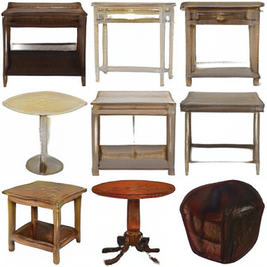

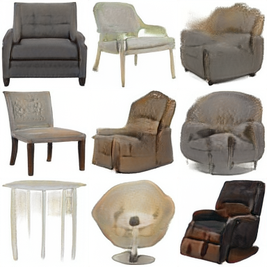

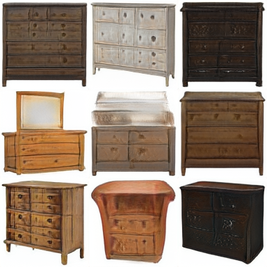

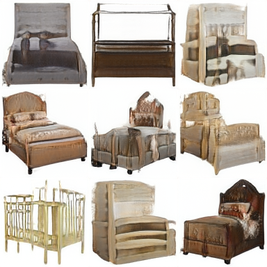

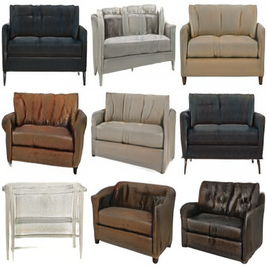

In [36]:
for label in range(5):
    imshow(createImageGrid(generate_images_from_seeds(seeds, label, 0.7), 0.7 , 3))

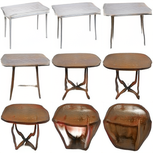

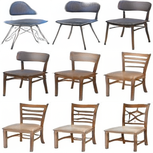

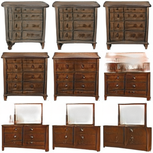

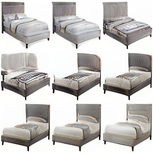

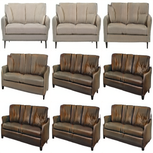

In [37]:
# Simple (Z) interpolation
zs = generate_zs_from_seeds([5015289, 9148088])

latent1 = zs[0]
latent2 = zs[1]

number_of_steps = 9

for label in range(5):
    imgs = generate_images(interpolate([latent1, latent2], number_of_steps), label, 1)
    number_of_images = len(imgs)
    imshow(createImageGrid(imgs, 0.4, 3))

In [45]:
# generating a MP4 movie

zs = generate_zs_from_seeds([421645, 6149575, 3487643, 3766864, 3857159, 5360657, 3720613])

number_of_steps = 100

# Example of reading a generated set of images, and storing as MP4.
%mkdir out

for label in range(5):
    imgs = generate_images(interpolate(zs, number_of_steps), label, 1.0)

    movieName = 'out/mov_{}.mp4'.format(label)

    with imageio.get_writer(movieName, mode='I', fps=60) as writer:
        for image in log_progress(list(imgs), name = "Creating animation"):
            writer.append_data(np.array(image))

In [ ]:
# Didn't run below

In [ ]:
# more complex example, interpolating in W instead of Z space.
zs = generate_zs_from_seeds([421645,6149575,3487643,3766864 ,3857159,5360657,3720613 ])

# It seems my truncation_psi is slightly less efficient in W space - I probably introduced an error somewhere...

dls = []
for z in zs:
  dls.append(convertZtoW(z ,truncation_psi=1.0))

number_of_steps = 100

imgs = generate_images_in_w_space(interpolate(dls,number_of_steps), 1.0)

%mkdir out
movieName = 'out/mov.mp4'

with imageio.get_writer(movieName, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(image))

# Projecting images onto the generatable manifold

StyleGAN2 comes with a projector that finds the closest generatable image based on any input image. This allows you to get a feeling for the diversity of the portrait manifold.

In [ ]:
!mkdir projection
!mkdir projection/imgs
!mkdir projection/out

# Now upload a single image to 'stylegan2/projection/imgs' (use the Files side panel). Image should be color PNG, with a size of 1024x1024.

In [ ]:
# Convert uploaded images to TFRecords
import dataset_tool
from sys import exit
dataset_tool.create_from_images("./projection/records/", "./projection/imgs/", True)

# Run the projector
import run_projector
import projector
import training.dataset
import training.misc
import os 

def project_real_images(dataset_name, data_dir, num_images, num_snapshots):
    proj = projector.Projector()
    proj.set_network(Gs)

    print('Loading images from "%s"...' % dataset_name)
    dataset_obj = training.dataset.load_dataset(data_dir=data_dir, tfrecord_dir=dataset_name, max_label_size=0, verbose=True, repeat=False, shuffle_mb=0)
    assert dataset_obj.shape == Gs.output_shape[1:]

    for image_idx in range(num_images):
        print('Projecting image %d/%d ...' % (image_idx, num_images))
        images, _labels = dataset_obj.get_minibatch_np(1)
        images = training.misc.adjust_dynamic_range(images, [0, 255], [-1, 1])
        run_projector.project_image(proj, targets=images, png_prefix=dnnlib.make_run_dir_path('projection/out/image%04d-' % image_idx), num_snapshots=num_snapshots)

project_real_images("records","./projection",1,100)

In [ ]:
# Create video 

import glob

imgs = sorted(glob.glob("projection/out/*step*.png"))

target_imgs = sorted(glob.glob("projection/out/*target*.png"))
assert len(target_imgs) == 1, "More than one target found?"
target_img = imageio.imread(target_imgs[0])

movieName = "projection/movie.mp4"
with imageio.get_writer(movieName, mode='I') as writer:
    for filename in log_progress(imgs, name = "Creating animation"):
        image = imageio.imread(filename)

        # Concatenate images with original target image
        w,h = image.shape[0:2]
        canvas = PIL.Image.new('RGBA', (w*2,h), 'white')
        canvas.paste(Image.fromarray(target_img), (0, 0))
        canvas.paste(Image.fromarray(image), (w, 0))

        writer.append_data(np.array(canvas))  

In [ ]:
# Now you can download the video (find it in the Files side panel under 'stylegan2/projection')

# To cleanup
!rm projection/out/*.*
!rm projection/records/*.*
!rm projection/imgs/*.*